In [1]:
import numpy as np
import pandas as pd
import squarify
import matplotlib
import matplotlib.pyplot as plt
from itertools import combinations
import networkx as nx
import math

In [2]:
LIST_STORES = ['NB4', 'NB5', 'NB3', 'ZS1', 'TZ2', 'TZ1', 'WH2', 'BB1', 'NJ2',
       'MAS', 'WH1', 'AQ1', 'NJ3', 'HZ1', 'JX1', 'YP1', 'YP2', 'JD1',
       'JD2', 'JS1', 'MH1', 'MH2', 'NH1', 'WGQ1', 'CS1', 'CS2', 'ZJG1',
       'CZ1', 'CZ2', 'CZ3', 'YZ1', 'ZJ1', 'DY1', 'DY2', 'WX3', 'NT1',
       'NT2', 'HM1', 'SZ1', 'SZ4', 'SZ2', 'KS1', 'SZ3', 'WX1', 'WX2',
       'WX4', 'SX1', 'NB6', 'WH3']

### Import Info dei negozi

#### Province dei negozi

In [3]:
# Code e città
df_city = pd.read_excel('data/store province.xlsx', index_col = 0)
dict_prov = dict(zip(df_city['Code'], df_city['Province']))
print("{:,} città".format(len(df_city)))
df_city.head()

52 città


,Code,Province
0,AQ1,ANHUI
1,BB1,ANHUI
2,CS1,JIANGSU
3,CS2,JIANGSU
4,CZ1,JIANGSU


### Import del piano di trasporto

In [4]:
# Address Data frame
df_plan = pd.read_excel('data/delivery records.xlsx', index_col = 0)
print("{:,} routes".format(len(df_plan)))
df_plan.head()

4,791 routes


,Month,Year-Week,Date,Capacity(T),Total_tons(T),List_Code
0,2016-9,2016-35,2016-09-01,3.5,2.91,['JX1']
1,2016-9,2016-35,2016-09-01,3.5,2.14,"['JS1', 'MH1', 'MH2']"
2,2016-9,2016-35,2016-09-01,3.5,1.50,['HZ1']
3,2016-9,2016-35,2016-09-01,3.5,2.30,['YP2']
4,2016-9,2016-35,2016-09-01,3.5,2.65,"['NH1', 'WGQ1']"


#### % per size del camion per ogni mese

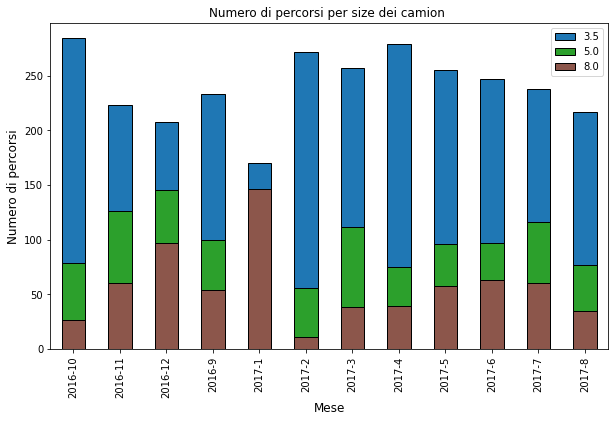

In [6]:
# Conteggio delle spedizioni per size/mese
df_count = pd.DataFrame(df_plan.groupby(['Capacity(T)', 'Month'])['Total_tons(T)'].count())
df_count.columns = ['Routes']
df_count['%Routes'] = (100 * df_count['Routes']/df_count['Routes'].sum()).round(2)

# Tabella Pivot
df_count = pd.pivot_table(df_count, index = 'Month', values = 'Routes', columns = 'Capacity(T)').fillna(0)
df_count

# Bar Plot
ax = df_count.plot.bar(figsize=(10, 6), edgecolor='black', y=3.5, color='tab:blue', legend= True)
df_count.plot.bar( edgecolor='black', y=5.0, color='tab:green', legend= True, ax = ax)
df_count.plot.bar( edgecolor='black', y=8.0, color='tab:brown', legend= True, ax = ax)
plt.xlabel('Mese', fontsize = 12)
plt.ylabel('Numero di percorsi', fontsize = 12)
plt.title('Numero di percorsi per size dei camion ', fontsize = 12)
plt.show()

### Computazione
#### Mapping delle colonne (booleano)

In [12]:
# Analisi
df_an = df_plan[['Month', 'Year-Week', 'Date', 'Capacity(T)','Total_tons(T)', 'List_Code']].copy()
df_an.columns = ['Month', 'Year-Week', 'Date', 'Size', 'Tons', 'Stores']

# Add boolean
for store in LIST_STORES:
    df_an[store] = df_an['Stores'].apply(lambda t: store in t)*1
    
# Numero di stores
df_an['#Stores'] = df_an[LIST_STORES].sum(axis =1)
print("{} Months".format(df_an['Month'].nunique()))
df_an.head()

12 Months


,Month,Year-Week,Date,Size,Tons,Stores,NB4,NB5,NB3,ZS1,...,SZ2,KS1,SZ3,WX1,WX2,WX4,SX1,NB6,WH3,#Stores
0,2016-9,2016-35,2016-09-01,3.5,2.91,['JX1'],0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2016-9,2016-35,2016-09-01,3.5,2.14,"['JS1', 'MH1', 'MH2']",0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,2016-9,2016-35,2016-09-01,3.5,1.50,['HZ1'],0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2016-9,2016-35,2016-09-01,3.5,2.30,['YP2'],0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2016-9,2016-35,2016-09-01,3.5,2.65,"['NH1', 'WGQ1']",0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


#### Numero di percorsi per numero di negozio/percorso

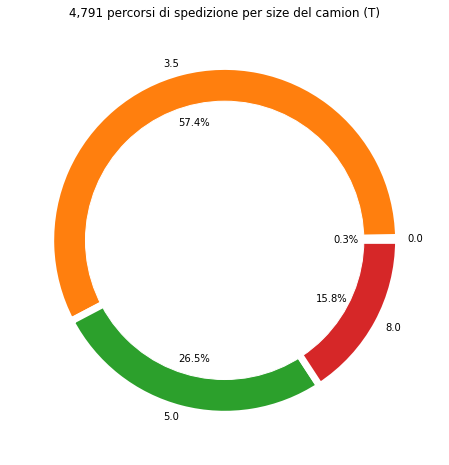

In [13]:
my_circle = plt.Circle( (0,0), 0.8, color='white')


df_an.groupby(['Size']).sum().plot.pie(figsize=(8, 8), y='#Stores', legend= False, pctdistance=0.7,
                                          autopct='%1.1f%%', labeldistance=1.05, 
                                          wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
plt.xlabel('Business Vertical')
plt.title('{:,} percorsi di spedizione per size del camion (T)'.format(len(df_an)))
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()

### Multiple Line Plot: Negozi per Percorso

In [14]:
df_strou = pd.DataFrame(df_an.groupby(['Month', 'Size'])['#Stores'].mean())
df_strou.columns = ['stores']
df_strou.reset_index(inplace = True)

# Tabella pivot
df_strou = pd.pivot_table(df_strou, index = 'Month', values = 'stores', columns = 'Size').fillna(0)[[3.5, 5.0, 8.0]]
df_strou.columns = ['3.5 T', '5 T', '8 T']
df_strou

,3.5 T,5 T,8 T
Month,,,
2016-10,1.866197,2.291139,2.370370
2016-11,1.843049,1.896825,2.116667
2016-12,1.793269,1.917241,1.927835
2016-9,1.802575,2.100000,2.222222
2017-1,1.864706,1.816794,1.808219
2017-2,2.113971,2.250000,2.909091
2017-3,1.918288,2.080357,2.500000
2017-4,1.867384,2.213333,2.769231
2017-5,1.811765,2.156250,2.344828


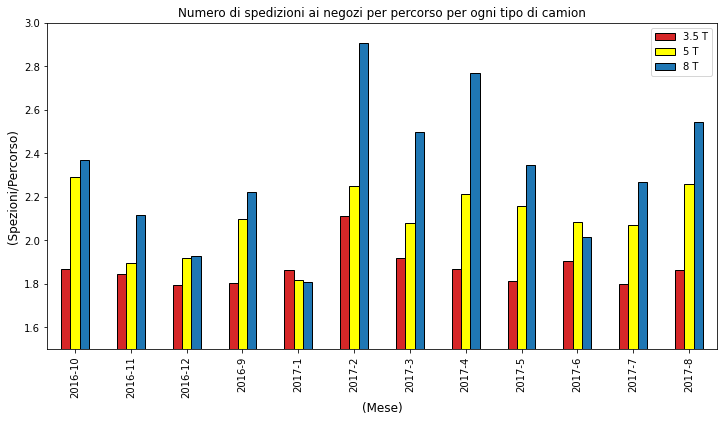

In [16]:
ax = df_strou.plot.bar(figsize = (12, 6), y = ['3.5 T', '5 T', '8 T'],
                           edgecolor = 'black',
                            color = ['tab:red', 'yellow', 'tab:blue'], 
                            legend = True)
plt.xlabel('(Mese)'
           , fontsize = 12)
plt.ylabel('(Spezioni/Percorso)'
           , fontsize = 12)
plt.title('Numero di spedizioni ai negozi per percorso per ogni tipo di camion'
          , fontsize = 12)
plt.ylim([1.5, 3])
plt.show()

## Costruzione dei grafi
### Creo i nodi

In [17]:
# Tutte le combo dei negozi
L1 = [i for i in combinations(LIST_STORES,2)]
df_nodes = pd.DataFrame({'Pair': L1})
# Source/Target
df_nodes['Source'] = df_nodes['Pair'].apply(lambda t: t[0])
df_nodes['Target'] = df_nodes['Pair'].apply(lambda t: t[1])
df_nodes.drop(['Pair'], axis =1, inplace = True)

print("{:,} combinazioni".format(len(df_nodes)))
df_nodes.head()

1,176 combinazioni


,Source,Target
0,NB4,NB5
1,NB4,NB3
2,NB4,ZS1
3,NB4,TZ2
4,NB4,TZ1


### Numero di Spedizioni

In [18]:
# Per mese
df_del1 = df_nodes.copy()
for m in df_an['Month'].unique():
    df_temp = df_an[df_an['Month'] == m]
    df_del1[m] = df_del1[['Source', 'Target']].apply(
        lambda t: (df_temp[t['Source']] * df_temp[t['Target']]).sum().sum()/2, 
                                                       axis = 1).astype(int)
df_del1['Total'] = df_del1[df_an['Month'].unique()].sum(axis=1)
print("{}/{} non zero".format((df_del1['Total']>0).sum(), len(df_del1)))
# Processo
df_del1.head()

94/1176 non zero


,Source,Target,2016-9,2016-10,2016-11,2016-12,2017-1,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,Total
0,NB4,NB5,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NB4,NB3,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NB4,ZS1,0,0,1,0,1,0,0,0,1,2,0,0,5
3,NB4,TZ2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NB4,TZ1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Spedizioni camion da 3.5

In [19]:
# Per Mese
df_del2 = df_nodes.copy()
for m in df_an['Month'].unique():
    df_temp = df_an[(df_an['Month'] == m) & (df_an['Size'] == 3.5)]
    df_del2[m] = df_del2[['Source', 'Target']].apply(
        lambda t: (df_temp[t['Source']] * df_temp[t['Target']]).sum().sum()/2, 
                                                       axis = 1).astype(int)
df_del2['Total'] = df_del2[df_an['Month'].unique()].sum(axis=1)
print("{}/{} non zero".format((df_del2['Total']>0).sum(), len(df_del2)))
# Processo
df_del2.head()

89/1176 non zero


,Source,Target,2016-9,2016-10,2016-11,2016-12,2017-1,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,Total
0,NB4,NB5,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NB4,NB3,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NB4,ZS1,0,0,1,0,0,0,0,0,1,1,0,0,3
3,NB4,TZ2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NB4,TZ1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Spedizioni camion da 5.0

In [20]:
# Per mese
df_del3 = df_nodes.copy()
for m in df_an['Month'].unique():
    df_temp = df_an[(df_an['Month'] == m) & (df_an['Size'] == 5.0)]
    df_del3[m] = df_del3[['Source', 'Target']].apply(
        lambda t: (df_temp[t['Source']] * df_temp[t['Target']]).sum().sum()/2, 
                                                       axis = 1).astype(int)
df_del3['Total'] = df_del3[df_an['Month'].unique()].sum(axis=1)
print("{}/{} non zero".format((df_del3['Total']>0).sum(), len(df_del2)))
# Processo
df_del3.head()

73/1176 non zero


,Source,Target,2016-9,2016-10,2016-11,2016-12,2017-1,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,Total
0,NB4,NB5,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NB4,NB3,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NB4,ZS1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,NB4,TZ2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NB4,TZ1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Spedizioni camion da 8.0

In [21]:
# Per mese
df_del4 = df_nodes.copy()
for m in df_an['Month'].unique():
    df_temp = df_an[(df_an['Month'] == m) & (df_an['Size'] == 8.0)]
    df_del4[m] = df_del4[['Source', 'Target']].apply(
        lambda t: (df_temp[t['Source']] * df_temp[t['Target']]).sum().sum()/2, 
                                                       axis = 1).astype(int)
df_del4['Total'] = df_del4[df_an['Month'].unique()].sum(axis=1)
print("{}/{} non zero".format((df_del4['Total']>0).sum(), len(df_del2)))
# Processo
df_del4.head()

60/1176 non zero


,Source,Target,2016-9,2016-10,2016-11,2016-12,2017-1,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,Total
0,NB4,NB5,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NB4,NB3,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NB4,ZS1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NB4,TZ2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NB4,TZ1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Network Graphs (All Sizes)

In [22]:
# Mese
df_graph = df_del1.copy().reset_index()
df_graph = df_graph[df_graph['Total']>0].copy().reset_index()

# Aggiungo la città
for dic, loc in zip([dict_prov], ['Province']):
    df_graph['Source ' + loc] = df_graph['Source'].map(dic)
    df_graph['Target ' + loc] = df_graph['Target'].map(dic)
# città uniche
PROVINCES = list(df_graph['Source Province'].unique()) + list(df_graph['Target Province'].unique()) 
n_prov = len(set(PROVINCES))

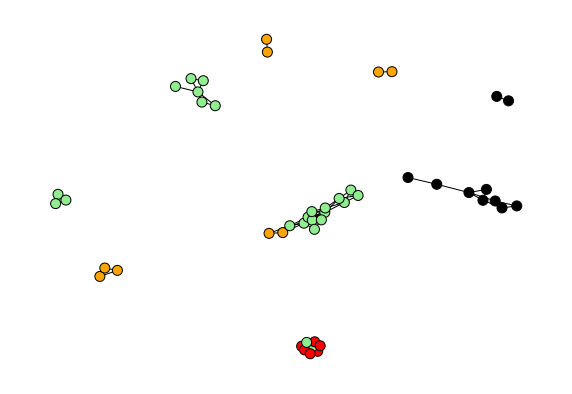

In [23]:
# Plot
fig, ax = plt.subplots(figsize = (10, 7))
G = nx.Graph()
for link in df_graph.index:
    G.add_edge(df_graph.iloc[link]['Source'],
             df_graph.iloc[link]['Target'])

df_cat = df_city.set_index('Code')
df_cat = df_cat.reindex(G.nodes())
df_cat['Province'] = pd.Categorical(df_cat['Province'])
df_cat['Province'].cat.codes

dict_color = dict(zip(['ZHEJIANG', 'ANHUI', 'JIANGSU', 'SHANGHAI'], ["black", "red", "lightgreen", "orange"]))

# posizioni delle labels
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
pos = nx.spring_layout(G)
pos_nodes = nudge(pos, 0, 0.1)  
nx.draw(G, with_labels=False, node_color=df_cat['Province'].map(dict_color),
       node_size=100, edgecolors='black', alpha = 1, 
        font_size = 11, font_color = 'black', width=1 , verticalalignment='top')
plt.show()

### 3.5 T Camion

In [25]:
# Mese
df_graph = df_del2.copy().reset_index()
df_graph = df_graph[df_graph['Total']>0].copy().reset_index()

# Aggiungo la città
for dic, loc in zip([dict_prov], ['Province']):
    df_graph['Source ' + loc] = df_graph['Source'].map(dic)
    df_graph['Target ' + loc] = df_graph['Target'].map(dic)
# Città uniche
PROVINCES = list(df_graph['Source Province'].unique()) + list(df_graph['Target Province'].unique()) 
n_prov = len(set(PROVINCES))

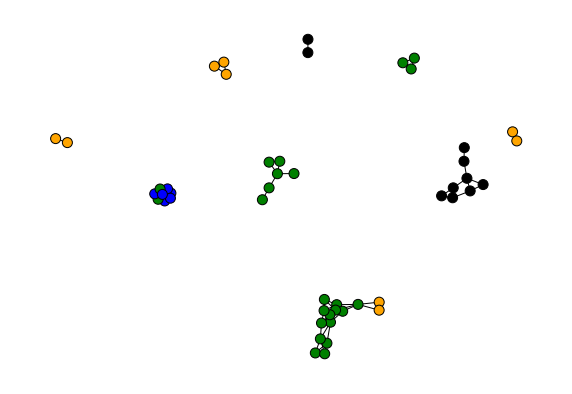

In [26]:
# Plot
fig, ax = plt.subplots(figsize = (10, 7))
G = nx.Graph()
for link in df_graph.index:
    G.add_edge(df_graph.iloc[link]['Source'],
             df_graph.iloc[link]['Target'])
df_cat = df_city.set_index('Code')
df_cat = df_cat.reindex(G.nodes())
df_cat['Province'] = pd.Categorical(df_cat['Province'])
df_cat['Province'].cat.codes

cmap = matplotlib.colors.ListedColormap(["black", "blue", "red", "green", "orange"])
dict_color = dict(zip(['ZHEJIANG', 'ANHUI', 'JIANGSU', 'SHANGHAI'], ["black", "blue", "green", "orange"]))
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
pos = nx.spring_layout(G)
pos_nodes = nudge(pos, 0, 0.1)  
nx.draw(G, with_labels=False, node_color=df_cat['Province'].map(dict_color),
       node_size=100, edgecolors='black', alpha = 1, 
        font_size = 11, font_color = 'black', width=1 , verticalalignment='top')

plt.show()

---

### Network Graph (Monthly)
#### Month (All Size)

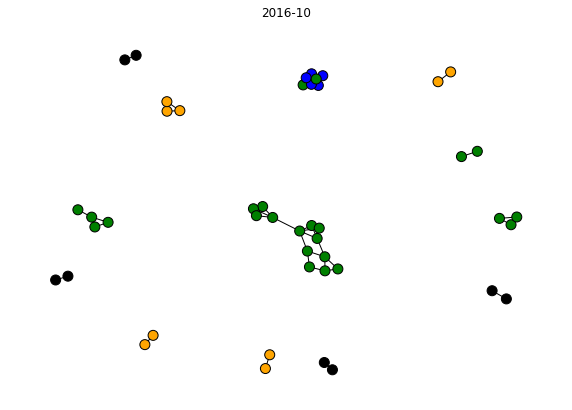

In [27]:
# mese
MTH = '2016-10'
df_del = df_del1.copy()

df_graph = df_del[df_del[MTH]>0].copy().reset_index()

for dic, loc in zip([dict_prov], ['Province']):
    df_graph['Source ' + loc] = df_graph['Source'].map(dic)
    df_graph['Target ' + loc] = df_graph['Target'].map(dic)
PROVINCES = list(df_graph['Source Province'].unique()) + list(df_graph['Target Province'].unique())
n_prov = len(set(PROVINCES))

# Plot
fig, ax = plt.subplots(figsize = (10, 7))
plt.rc('axes', titlesize=20)     # fontsize of the axes title
G = nx.Graph()
for link in df_graph.index:
    G.add_edge(df_graph.iloc[link]['Source'],
             df_graph.iloc[link]['Target'])

df_cat = df_city.set_index('Code')
df_cat = df_cat.reindex(G.nodes())
df_cat['Province'] = pd.Categorical(df_cat['Province'])
df_cat['Province'].cat.codes

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
pos = nx.spring_layout(G)
pos_nodes = nudge(pos, 0, 0.1)  

nx.draw(G, with_labels=False, node_color=df_cat['Province'].map(dict_color),
       node_size=100, edgecolors='black', alpha = 1, 
        font_size = 11, font_color = 'black', width=1 , verticalalignment='top')
plt.title("{}".format(MTH), fontsize=12)
plt.show()

#### Month (3.5T)

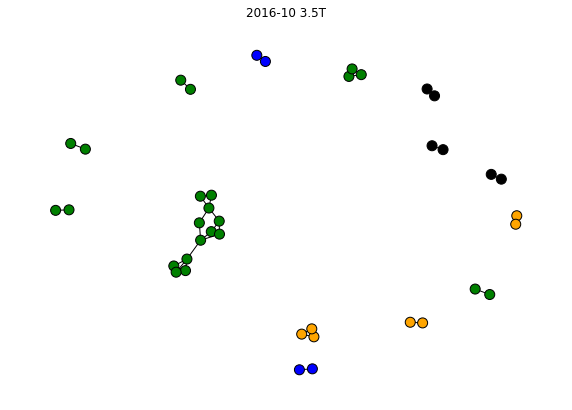

In [28]:
# Mese
df_del = df_del2.copy()
MTH = '2016-10'
df_graph = df_del[df_del[MTH]>0].copy().reset_index()
for dic, loc in zip([dict_prov], ['Province']):
    df_graph['Source ' + loc] = df_graph['Source'].map(dic)
    df_graph['Target ' + loc] = df_graph['Target'].map(dic)
PROVINCES = list(df_graph['Source Province'].unique()) + list(df_graph['Target Province'].unique())
n_prov = len(set(PROVINCES))

# Plot
fig, ax = plt.subplots(figsize = (10, 7))
plt.rc('axes', titlesize=20)
G = nx.Graph()
for link in df_graph.index:
    G.add_edge(df_graph.iloc[link]['Source'],
             df_graph.iloc[link]['Target'])

df_cat = df_city.set_index('Code')
df_cat = df_cat.reindex(G.nodes())
df_cat['Province'] = pd.Categorical(df_cat['Province'])
df_cat['Province'].cat.codes

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
pos = nx.spring_layout(G)
pos_nodes = nudge(pos, 0, 0.1)  

nx.draw(G, with_labels=False, node_color=df_cat['Province'].map(dict_color),
       node_size=100, edgecolors='black', alpha = 1, 
        font_size = 11, font_color = 'black', width=1 , verticalalignment='top')
plt.title("{} 3.5T".format(MTH), fontsize=12)
plt.show()

#### Month (5T)

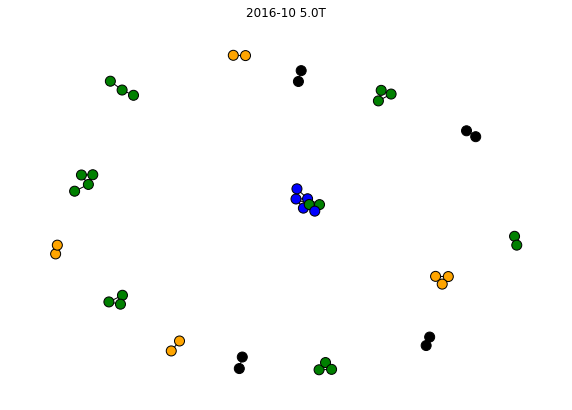

In [29]:
# Mese
df_del = df_del3.copy()
df_graph = df_del[df_del[MTH]>0].copy().reset_index()
for dic, loc in zip([dict_prov], ['Province']):
    df_graph['Source ' + loc] = df_graph['Source'].map(dic)
    df_graph['Target ' + loc] = df_graph['Target'].map(dic)
PROVINCES = list(df_graph['Source Province'].unique()) + list(df_graph['Target Province'].unique())
n_prov = len(set(PROVINCES))

# Plot
fig, ax = plt.subplots(figsize = (10, 7))
plt.rc('axes', titlesize=20)     # fontsize of the axes title
G = nx.Graph()
for link in df_graph.index:
    G.add_edge(df_graph.iloc[link]['Source'],
             df_graph.iloc[link]['Target'])

df_cat = df_city.set_index('Code')
df_cat = df_cat.reindex(G.nodes())
df_cat['Province'] = pd.Categorical(df_cat['Province'])
df_cat['Province'].cat.codes

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
pos = nx.spring_layout(G)
pos_nodes = nudge(pos, 0, 0.1)  

nx.draw(G, with_labels=False, node_color=df_cat['Province'].map(dict_color),
       node_size=100, edgecolors='black', alpha = 1, 
        font_size = 11, font_color = 'black', width=1 , verticalalignment='top')
plt.title("{} 5.0T".format(MTH), fontsize=12)
plt.show()

#### Month (8T)

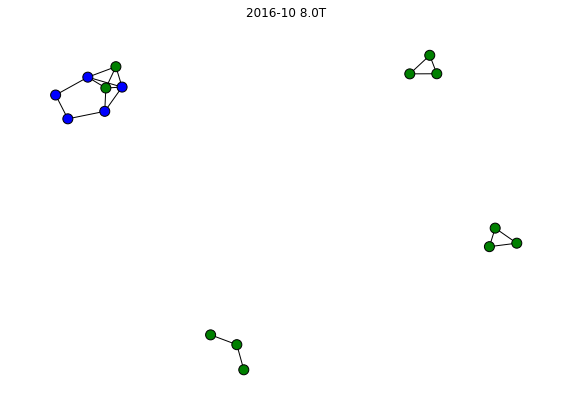

In [30]:
# Mese
df_del = df_del4.copy()
df_graph = df_del[df_del[MTH]>0].copy().reset_index()
for dic, loc in zip([dict_prov], ['Province']):
    df_graph['Source ' + loc] = df_graph['Source'].map(dic)
    df_graph['Target ' + loc] = df_graph['Target'].map(dic)
PROVINCES = list(df_graph['Source Province'].unique()) + list(df_graph['Target Province'].unique())
n_prov = len(set(PROVINCES))

fig, ax = plt.subplots(figsize = (10, 7))
plt.rc('axes', titlesize=20)
G = nx.Graph()
for link in df_graph.index:
    G.add_edge(df_graph.iloc[link]['Source'],
             df_graph.iloc[link]['Target'])

df_cat = df_city.set_index('Code')
df_cat = df_cat.reindex(G.nodes())
df_cat['Province'] = pd.Categorical(df_cat['Province'])
df_cat['Province'].cat.codes

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
pos = nx.spring_layout(G)
pos_nodes = nudge(pos, 0, 0.1)  

nx.draw(G, with_labels=False, node_color=df_cat['Province'].map(dict_color),
       node_size=100, edgecolors='black', alpha = 1, 
        font_size = 11, font_color = 'black', width=1 , verticalalignment='top')
plt.title("{} 8.0T".format(MTH), fontsize=12)
plt.show()